In [30]:
import pandas as pd
import os
if os.path.exists("data/articles.parquet"):
    articles = pd.read_parquet("data/articles.parquet")
else:
    articles = pd.read_csv("data/articles_metadata.csv")
    articles.to_parquet("data/articles.parquet")

In [2]:
import pickle
embeddings = pickle.load(open("data/articles_embeddings.pickle", "rb"))

In [3]:
type(embeddings)

numpy.ndarray

In [4]:
print(f" Shape of embeddings {embeddings.shape}, Shape of articles {articles.shape}")

 Shape of embeddings (364047, 250), Shape of articles (364047, 5)


#### Chaque ligne du tableau d'embeddings correspond à un article

In [5]:
articles.head(10)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
5,5,1,1407413929000,0,196
6,6,1,1409896802000,0,203
7,7,1,1412559620000,0,154
8,8,1,1414351550000,0,209
9,9,1,1412526792000,0,181


In [6]:
import os
import glob
list_clicks = []
if os.path.exists("data/clicks.parquet"):
    df_clicks = pd.read_parquet("data/clicks.parquet")
else:
    for click_path in glob.glob("data/clicks/clicks_hour_*.csv"):
        list_clicks.append(pd.read_csv(click_path))
    df_clicks= pd.concat(list_clicks)
    df_clicks.to_parquet('data/clicks.parquet')
df_clicks.head(10)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
index,,,,,,,,,,,,
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2
5,77136,1507865796257845,1507865796000,2,96210,1507866163178,4,3,2,1,25,2
6,16921,1507865798301846,1507865798000,2,159197,1507865858065,4,1,17,1,9,1
7,16921,1507865798301846,1507865798000,2,337441,1507865888065,4,1,17,1,9,1
8,28126,1507865802651847,1507865802000,4,96210,1507865841576,4,1,17,1,25,2


In [7]:
import seaborn as sns
df_clicks.shape

(2988181, 12)

In [8]:
print(f"Nombre d'utilisateurs avec les informations de click {df_clicks['user_id'].unique().shape[0]}")

Nombre d'utilisateurs avec les informations de click 322897


In [9]:
print(f"Nombre d'articles {articles['article_id'].unique().shape[0]}")

Nombre d'articles 364047


In [12]:
nbr_clicks = df_clicks['user_id'].value_counts()
print(f"Nombre d'utilisateurs avec plus de 100 clicks {nbr_clicks[nbr_clicks>100].shape[0]}")

Nombre d'utilisateurs avec plus de 100 clicks 1112


In [13]:
articles_clicks_per_user =df_clicks[['user_id','click_article_id']].assign(rating=1).groupby(['user_id','click_article_id'], as_index=False).agg({'rating':'sum'})

In [14]:
articles_clicks_per_user.rating.max()

33

In [15]:
articles_clicks_per_user.head(10)

,user_id,click_article_id,rating
0,0,68866,1
1,0,87205,1
2,0,87224,1
3,0,96755,1
4,0,157541,1
5,0,160158,1
6,0,233470,1
7,0,313996,1
8,1,36162,1
9,1,59758,1


<Axes: ylabel='rating'>

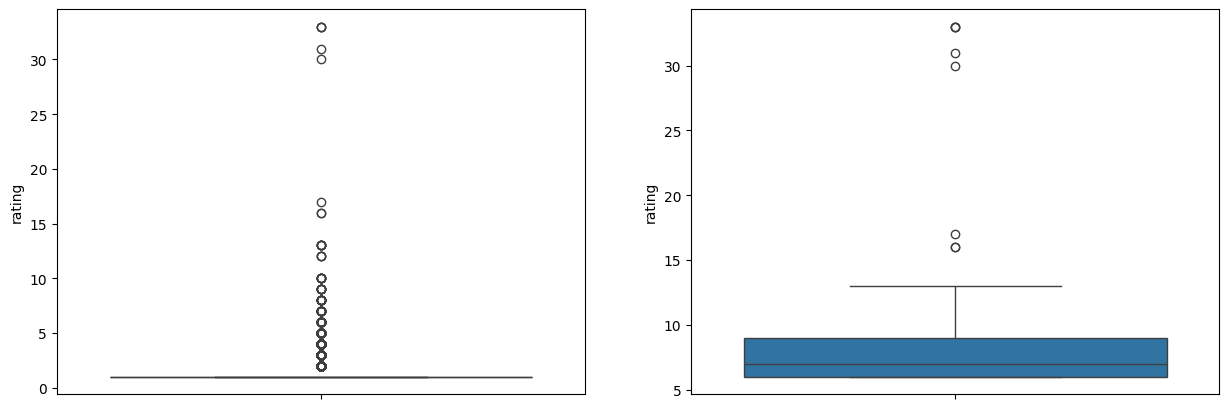

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(articles_clicks_per_user['rating'], ax=ax[0])
sns.boxplot(articles_clicks_per_user.loc[articles_clicks_per_user.rating>5,'rating'], ax=ax[1])

In [28]:
articles_clicks_per_user[articles_clicks_per_user.rating>10].groupby('user_id').agg({'rating':'sum'}).index

Index([2520, 2546, 10188, 14073, 16280, 26751, 33937, 65739, 188046], dtype='int64', name='user_id')

#### Classes déséquilibrées : la majorité des clicks par articles sont de 1-3

In [17]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
articles_clickuser_filtered =articles_clicks_per_user[articles_clicks_per_user.rating>3]
# définir le format : ratings entre 0 et 33
reader = Reader(rating_scale=(1, 33))
data = Dataset.load_from_df(articles_clickuser_filtered, reader)

# séparer train/test (facultatif si vous voulez évaluer)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [18]:
articles_clickuser_filtered['rating'].mean()

5.157221206581353

#### On va trouver le user avec le plus de clicks

In [19]:
articles_clicks_per_user[articles_clicks_per_user.rating>30]

,user_id,click_article_id,rating
349859,16280,43032,31
349865,16280,68851,33
349924,16280,237071,33
349969,16280,363925,33


In [20]:
algo = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)
algo.fit(trainset)
# évaluation (RMSE) si on veut
predictions = algo.test(testset)
from surprise import accuracy
print("RMSE =", accuracy.rmse(predictions))

RMSE: 1.3477
RMSE = 1.347704865848684


In [22]:
pickle.dump(algo, open('model.pkl', 'wb'))

In [58]:
from surprise.model_selection import cross_validate
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(f"RMSE moyen : {results['test_rmse'].mean():.4f} ± {results['test_rmse'].std():.4f}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.6989  3.5989  3.2275  2.7004  1.9005  2.6252  0.7348  
MAE (testset)     1.1692  1.5257  1.3310  1.3659  1.3387  1.3461  0.1133  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
RMSE moyen : 2.6252 ± 0.7348


In [21]:
def recommander_5(id_user, algo, df_meta, df_click_rating):
    all_items = df_meta["article_id"].unique()
    seen = set(df_click_rating.loc[df_click_rating.user_id==id_user, "click_article_id"])
    candidates = [i for i in all_items if i not in seen]
    preds = [ (i, algo.predict(id_user, i).est) for i in candidates ]
    top5 = sorted(preds, key=lambda x: x[1], reverse=True)[:5]
    return df_meta.set_index("article_id").loc[[i for i,_ in top5]]
recos = recommander_5(16280, algo, articles, articles_clicks_per_user)
print(recos)

            category_id  created_at_ts  publisher_id  words_count
article_id                                                       
96173               209  1502368298000             0          204
166596              289  1500891937000             0          149
173375              299  1507061279000             0          163
237807              375  1507359658000             0          162
211863              340  1505973657000             0          190


In [59]:
from collections import defaultdict
# --- on construit l’anti-testset pour générer des prédictions sur tous les items non vus ---
anti_testset = trainset.build_anti_testset()
predictions = algo.test(anti_testset)

In [23]:
predictions[0]

Prediction(uid=48642, iid=158046, r_ui=9.344827586206897, est=9.331310757771664, details={'was_impossible': False})

In [60]:
len(predictions)

80403

In [61]:

def get_top_n(preds, n=5):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in preds:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for iid, _ in user_ratings[:n]]
    return top_n

top_n = get_top_n(predictions, n=5)

# --- construire la vérité terrain à partir du testset ---
left_out = defaultdict(list)
for uid, iid, true_r in testset:
    #todo: faux, vrai dans le cas 0,1 ici 1,33
    if true_r > 0:
        left_out[uid].append(iid)

# --- calcul Precision@K et Recall@K ---
def precision_recall_at_k(top_n, left_out, k=5):
    precisions = []
    recalls = []
    for uid, true_items in left_out.items():
        rec_items = top_n.get(uid, [])
        hit_count = len(set(rec_items) & set(true_items))
        precisions.append(hit_count / k)
        recalls.append(hit_count / len(true_items))
    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)

prec, rec = precision_recall_at_k(top_n, left_out, k=5)
print(f"Precision@5 = {prec:.3f}, Recall@5 = {rec:.3f}")

Precision@5 = 0.000, Recall@5 = 0.000


#### Similarité Cosinus sur les embeddings des articles
##### Abandonné, trop long, même avec PCA

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
pca = PCA(n_components=5, random_state=42)
emb_pca = pca.fit_transform(embeddings)
emb_pca.shape
#sim_matrix = cosine_similarity(emb_pca)

(364047, 5)

In [27]:
# mapping id ↔ index
idx_map = {aid:i for i,aid in enumerate(articles.article_id)}

In [28]:
import hnswlib
import numpy as np
dim = embeddings.shape[1]
p = hnswlib.Index(space='cosine', dim=dim)
p.init_index(max_elements=embeddings.shape[0], ef_construction=200, M=16)
p.add_items(embeddings, np.arange(embeddings.shape[0]))
p.save_index('index.hnsw')
p.set_ef(50)  # qualité/vitesse

### Les 5 articles les plus similaires pour chaque articles vu par l'utilisateur

In [29]:
user_articles=articles_clicks_per_user[articles_clicks_per_user.user_id==16280]["click_article_id"]
embed_ids = [idx_map[article_id] for article_id in user_articles]
labels, distances = p.knn_query(embeddings[embed_ids], k=5)

### Hybridation des recommandations entre SVD et Contenu
#### Pour tous articles non vues par l'utilisateur, on va calculer la prédiction à partir de la svd de surprise. On va couplé ce résultat avec une similarité cosinus entre les articles candidats et ceux vus par l'utilisateur. Les deux tableaux de résultats sont de dimension 1 et de taille du nombre d'articles non vus.


In [65]:
all_items = articles["article_id"].unique()
candidates = [idx_map[i] for i in all_items if i not in user_articles]

In [72]:
embeddings_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

In [73]:
E_clicked = embeddings_norm[embed_ids]
E_candidates = embeddings_norm[candidates]

In [110]:
sim_matrix = np.dot(E_candidates, E_clicked.T)
print(sim_matrix.shape)

(363925, 122)


In [96]:
max_sim_cand = sim_matrix.max(axis=1)
score_contenu = {idx_map[i]: max_sim_cand[i] for i in range(len(max_sim_cand))}
svd_scores = {idx_map[i]: algo.predict(16280,i).est for i in range(len(candidates))}

In [107]:
alpha = 0.1
score_final = {idx_map[i]: alpha*svd_scores[i] + (1-alpha)*score_contenu[i] for i in range(len(score_contenu))}

In [108]:
top5 = sorted(score_final.items(), key=lambda x: x[1], reverse=True)[:5]

In [109]:
articles.set_index("article_id").loc[[i for i,_ in top5]]

,category_id,created_at_ts,publisher_id,words_count
article_id,,,,
237071,375,1499710604000,0,161
68851,136,1501421333000,0,278
43032,68,1402293601000,0,148
38823,60,1504598401000,0,262
124749,250,1507316335000,0,192


In [106]:
top5_svd = sorted(svd_scores.items(), key=lambda x: x[1], reverse=True)[:5]
articles.set_index("article_id").loc[[i for i,_ in top5_svd]]


,category_id,created_at_ts,publisher_id,words_count
article_id,,,,
237071,375,1499710604000,0,161
68851,136,1501421333000,0,278
43032,68,1402293601000,0,148
38823,60,1504598401000,0,262
272145,399,1507181457000,0,197


In [111]:
top5_svd = sorted(score_contenu.items(), key=lambda x: x[1], reverse=True)[:5]
articles.set_index("article_id").loc[[i for i,_ in top5_svd]]

,category_id,created_at_ts,publisher_id,words_count
article_id,,,,
124749,250,1507316335000,0,192
336223,437,1507555700000,0,122
31836,26,1507553479000,0,175
156560,281,1506957280000,0,185
233688,375,1507747802000,0,210
